In [16]:
import numpy as np
import matplotlib.pyplot as plt
from enum import Enum
import pandas as pd

In [23]:
class Trajectory():
    def __init__(self, file_name):
        pose = pd.read_csv(file_name, sep=' ', names=['x1', 'x2', 'x3', 'x4', 'x5', 'x6', 'x7', 'x8', 'x9', 'x10', 'x11', 'x12'])
        self.pose = np.asarray(pose).reshape(-1, 3, 4)
        self.trajectory = self._trajectory(self.pose)
        
    def _trajectory(self, x):
        origin = np.matrix([[0],
                            [0],
                            [0],
                            [1]])
        points = []
        for i in range(x.shape[0]):
            mat = np.asmatrix(x[i])
            transform = mat*origin
            points.append(np.asarray(transform))
        traj = np.asarray(points).reshape(-1,3)
        return traj

class Plot:
    def __init__(self, *args):
        self.n_files = len(args)
        self.label = []
        self.traj = []
        for i in range(self.n_files):
            self.label.append(args[i].split('/')[2].split('.')[0].split('_')[2])
            self.traj.append(Trajectory(args[i]).trajectory)
        
    def plotXYZ(self):
        plt.figure(figsize=(10,15))
        plt.subplot(3,1,1)
        for i in range(self.n_files):
            plt.plot(self.traj[i][:,0], label=self.label[i])
        plt.ylabel('x')
        plt.legend()

        plt.subplot(3,1,2)
        for i in range(self.n_files):
            plt.plot(self.traj[i][:,1], label=self.label[i])
        plt.ylabel('y')
        plt.legend()

        plt.subplot(3,1,3)
        for i in range(self.n_files):
            plt.plot(self.traj[i][:,2], label=self.label[i])
        plt.ylabel('z')
        plt.xlabel('index')
        plt.legend()
        plt.show()

In [24]:
def HornMethod(GT, TEST):
    target_mean = GT.mean(0)
    estimate_mean = TEST.mean(0)
    
    target =  GT - target_mean
    estimate =  TEST - estimate_mean

    W = np.dot(target.T, estimate)

    U,D,V = np.linalg.svd(W,full_matrices=True,compute_uv=True)
    
    R = np.dot(U, V)
    t = target_mean - np.dot(R, estimate_mean)
    T = np.vstack([np.hstack([R, t.reshape(3,1)]), np.array([0,0,0,1])])
    return T
    
def APE(gt_pose, est_pose, T):
    ape_trans = []
    ape_rot = []
    for i in range(gt_pose.shape[0]):
        Q = np.vstack([gt_pose[i], np.array([0,0,0,1])])
        P = np.vstack([est_pose[i], np.array([0,0,0,1])])
        E = np.dot(np.linalg.inv(Q),np.dot(T,P))
        
        ape_trans.append(np.linalg.norm(E[:3,3]))
        ape_rot.append(np.arccos((np.trace(E[:3,:3])-1)/2))
    return ape_trans, ape_rot

def RPE(gt_pose, est_pose):
    rpe_trans = []
    rpe_rot = []
    delta = 1
    for i in range(gt_pose.shape[0]-delta):
        Q = np.vstack([gt_pose[i], np.array([0,0,0,1])])
        Q_delta = np.vstack([gt_pose[i+delta], np.array([0,0,0,1])])
        Q = np.dot(np.linalg.inv(Q), Q_delta)
        P = np.vstack([est_pose[i], np.array([0,0,0,1])])
        P_delta = np.vstack([est_pose[i+delta], np.array([0,0,0,1])])
        P = np.dot(np.linalg.inv(P), P_delta)
        
        E = np.dot(np.linalg.inv(Q),P)
        
        rpe_trans.append(np.linalg.norm(E[:3,3]))
        rpe_rot.append(np.arccos((np.trace(E[:3,:3])-1)/2))
    return rpe_trans, rpe_rot

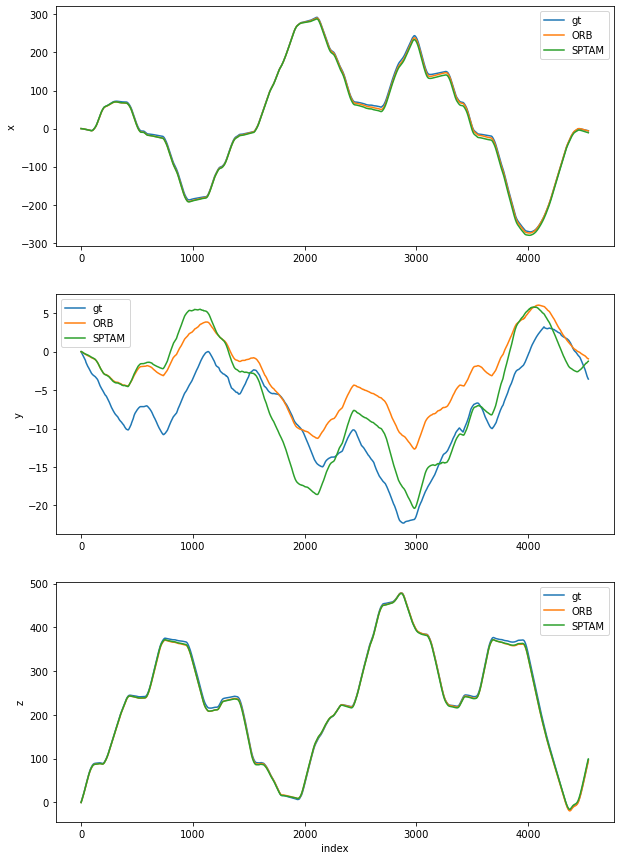

In [26]:
GT = './data/KITTI_00_gt.txt'
ORB = './data/KITTI_00_ORB.txt'
SPTAM = './data/KITTI_00_SPTAM.txt'

X = Plot(GT, ORB, SPTAM)
X.plotXYZ()

In [ ]:
gt_traj = Trajectory(GT).trajectory
orb_traj = Trajectory(ORB).trajectory

T = HornMethod(gt_traj, orb_traj)

gt_pose = Trajectory(GT).pose
orb_pose = Trajectory(ORB).pose

ape_trans, ape_rot = APE(gt_pose, orb_pose, T)
rpe_trans, rpe_rot = RPE(gt_pose, orb_pose)

In [ ]:
plt.figure(figsize=(10,10))
plt.subplot(2,1,1)
plt.plot(ape_trans, label='APE_translation')
plt.xlabel('index')
plt.ylabel('ape[m]')

plt.subplot(2,1,2)
plt.plot(ape_rot, label='APE_rotation')
plt.xlabel('index')
plt.ylabel('ape[rad]')

plt.show()

In [ ]:
plt.figure(figsize=(10,10))
plt.subplot(2,1,1)
plt.plot(rpe_trans, label='APE_translation')
plt.xlabel('index')
plt.ylabel('rpe[m]')

plt.subplot(2,1,2)
plt.plot(rpe_rot, label='APE_rotation')
plt.xlabel('index')
plt.ylabel('rpe[rad]')

plt.show()

In [ ]:
import seaborn as sns

sns.set_theme()
sns.displot(data=rpe_trans, kde=True)
sns.displot(data=ape_trans, kde=True)
plt.show()


In [ ]:
GT = './data/KITTI_00_gt.txt'
ORB = './data/KITTI_00_ORB.txt'
SPTAM = './data/KITTI_00_SPTAM.txt'

X = (GT, ORB, SPTAM)
print(len(X))
print(X[1][0])